
NEURAL OPERATOR WITH GENETIC FEATURES (FIXED)
Predicting FUTURE trajectories from early measurements
DATA LOADED WITH GENETIC FEATURES
Total samples: 281
Conditions: ['F503_C1', 'F503_C2', 'F504_C1', 'F504_C2', 'F505_C1', 'F505_C2', 'F506_C1', 'F506_C2']
Time range: 22.2h to 118.6h

CREATING TRAINING SEQUENCES (FIXED)
Early window: 0-50h (input)
Future window: 50h+ (prediction target)

✓ Created 29 sequences
  Average early points: 2.7
  Average future points: 7.0

Sequences per condition:
  F503_C1: 4 replicates
  F503_C2: 3 replicates
  F504_C1: 4 replicates
  F504_C2: 3 replicates
  F505_C1: 4 replicates
  F505_C2: 3 replicates
  F506_C1: 4 replicates
  F506_C2: 4 replicates

BASELINE COMPARISON (Future Predictions Only)

Baseline R² (future predictions only):
  Last Value Forward: -2.9374 (+/- 3.1998)
  Linear Extrapolation: -5.0702 (+/- 12.6417)

TRAINING FULL MODEL FOR VISUALIZATION
Train: 23 sequences, Val: 6 sequences
✓ Training complete! Best val loss: 0.008678


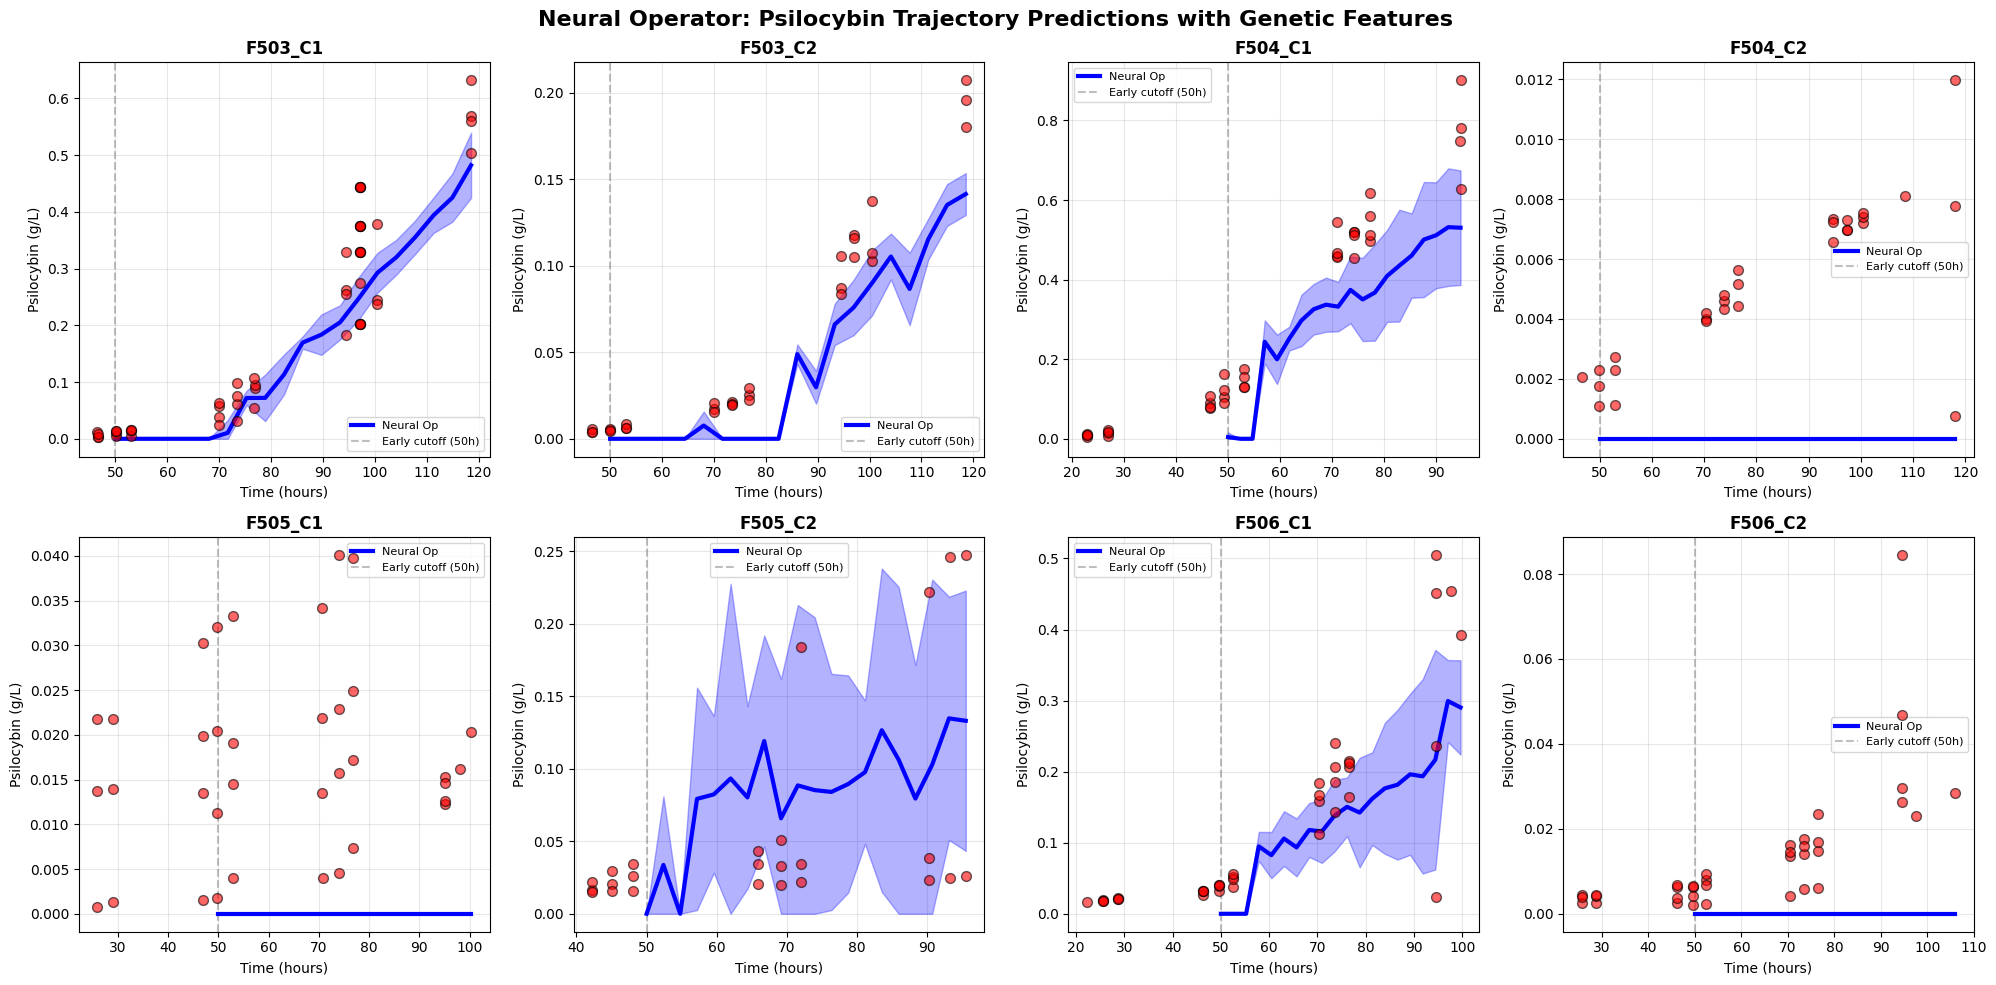


✓ Figure: Neural operator predictions (8 conditions)

LEAVE-ONE-CONDITION-OUT CROSS-VALIDATION

Holding out: F503_C1
  R² = -4606.6147, RMSE = 12.6909 g/L

Holding out: F503_C2
  R² = -24925.2656, RMSE = 9.9131 g/L

Holding out: F504_C1
  R² = -2191.8296, RMSE = 8.9526 g/L

Holding out: F504_C2
  R² = -47233260.0000, RMSE = 15.6414 g/L

Holding out: F505_C1
  R² = -95668.2578, RMSE = 2.9864 g/L

Holding out: F505_C2
  R² = -22076.8145, RMSE = 12.0033 g/L

Holding out: F506_C1
  R² = -10541.2148, RMSE = 11.9800 g/L

Holding out: F506_C2
  R² = -1395770.3750, RMSE = 18.3683 g/L

CROSS-VALIDATION SUMMARY
condition            r2      rmse  n_test        val_loss
  F503_C1 -4.606615e+03 12.690856       4  tensor(9.2885)
  F503_C2 -2.492527e+04  9.913120       3  tensor(3.9326)
  F504_C1 -2.191830e+03  8.952629       4 tensor(12.0801)
  F504_C2 -4.723326e+07 15.641408       3 tensor(10.1237)
  F505_C1 -9.566826e+04  2.986439       4  tensor(5.2984)
  F505_C2 -2.207681e+04 12.003336       3 

In [3]:
"""
Neural Operator for Psilocybin Production Trajectory Prediction
================================================================

Fixed approach: Predict FUTURE timepoints only from early measurements + genetics
Evaluate only on the future window where predictions matter

Dataset: mltest.xlsx with 8 conditions (F503_C1, F503_C2, etc.)
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import re
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PART 1: Load Data and Add Genetic Features
# ============================================================================

def load_data_with_genetics(filepath='../data/subs_omics_data/mltest.xlsx'):
    """Load data and add genetic feature encoding"""
    
    df = pd.read_excel(filepath)
    df = df.rename(columns={"Hours": "Time"})
    
    # Extract strain/replicate
    df['Strain'] = df['SampleID'].str.extract(r'(F\d{2,3}_C\d+)', flags=re.IGNORECASE)[0]
    df['Replicate'] = df['SampleID'].str.extract(r'R(\d+)')[0]
    df = df.dropna(subset=['Psilocybin g/L'])
    
    # Genetic features
    genetic_features = {
        'F503_C1': {'ylAro1': 0, 'ylAro2': 0, 'ylAro4': 0, 'ylTrp2': 0, 'PcCpr': 0},
        'F506_C1': {'ylAro1': 1, 'ylAro2': 1, 'ylAro4': 0, 'ylTrp2': 0, 'PcCpr': 0},
        'F503_C2': {'ylAro1': 0, 'ylAro2': 0, 'ylAro4': 1, 'ylTrp2': 1, 'PcCpr': 0},
        'F504_C1': {'ylAro1': 1, 'ylAro2': 1, 'ylAro4': 1, 'ylTrp2': 1, 'PcCpr': 0},
        'F504_C2': {'ylAro1': 0, 'ylAro2': 0, 'ylAro4': 0, 'ylTrp2': 0, 'PcCpr': 1},
        'F505_C2': {'ylAro1': 1, 'ylAro2': 1, 'ylAro4': 0, 'ylTrp2': 0, 'PcCpr': 1},
        'F505_C1': {'ylAro1': 0, 'ylAro2': 0, 'ylAro4': 1, 'ylTrp2': 1, 'PcCpr': 1},
        'F506_C2': {'ylAro1': 1, 'ylAro2': 1, 'ylAro4': 1, 'ylTrp2': 1, 'PcCpr': 1}
    }
    
    for gene in ['ylAro1', 'ylAro2', 'ylAro4', 'ylTrp2', 'PcCpr']:
        df[gene] = df['Strain'].map(lambda x: genetic_features.get(x, {}).get(gene, 0))
    
    print("="*70)
    print("DATA LOADED WITH GENETIC FEATURES")
    print("="*70)
    print(f"Total samples: {len(df)}")
    print(f"Conditions: {sorted(df['Strain'].dropna().unique())}")
    print(f"Time range: {df['Time'].min():.1f}h to {df['Time'].max():.1f}h")
    
    return df, genetic_features


# ============================================================================
# PART 2: Create Training Sequences (Fixed)
# ============================================================================

def create_training_sequences(df, early_cutoff=50):
    """
    Create sequences that predict FUTURE timepoints from early measurements
    Key fix: Store early and future separately, evaluate only on future
    """
    sequences = []
    
    print(f"\n{'='*70}")
    print("CREATING TRAINING SEQUENCES (FIXED)")
    print(f"{'='*70}")
    print(f"Early window: 0-{early_cutoff}h (input)")
    print(f"Future window: {early_cutoff}h+ (prediction target)\n")
    
    for strain in sorted(df['Strain'].dropna().unique()):
        strain_data = df[df['Strain'] == strain].copy()
        
        for rep in sorted(strain_data['Replicate'].dropna().unique()):
            run_data = strain_data[strain_data['Replicate'] == rep].sort_values('Time').reset_index(drop=True)
            
            if len(run_data) < 3:
                continue
            
            # Split early and future
            early_mask = run_data['Time'] <= early_cutoff
            early_data = run_data[early_mask]
            future_data = run_data[~early_mask]
            
            if len(early_data) < 1 or len(future_data) < 1:
                continue
            
            # Genetic features
            genetic_feats = run_data[['ylAro1', 'ylAro2', 'ylAro4', 'ylTrp2', 'PcCpr']].iloc[0].values
            
            # Early features
            early_features = np.concatenate([
                [early_data['Time'].max()],
                [early_data['Biomass (g/L)'].mean()],
                [early_data['Biomass (g/L)'].max()],
                [early_data['OD600 (N/A)'].mean()],
                [early_data['Psilocin g/L'].mean()],
                [early_data['Psilocin g/L'].max()],
                [early_data['Baeocystine g/L'].mean()],
                [early_data['Tryptamine g/L'].mean()],
                [early_data['Psilocybin g/L'].mean()],
                [early_data['Psilocybin g/L'].max()],
                genetic_feats
            ])
            
            sequences.append({
                'strain': strain,
                'replicate': rep,
                'features': early_features,
                'early_time': early_data['Time'].values,
                'early_psilocybin': early_data['Psilocybin g/L'].values,
                'future_time': future_data['Time'].values,
                'future_psilocybin': future_data['Psilocybin g/L'].values,
                'full_time': run_data['Time'].values,
                'full_psilocybin': run_data['Psilocybin g/L'].values,
            })
    
    print(f"✓ Created {len(sequences)} sequences")
    print(f"  Average early points: {np.mean([len(s['early_time']) for s in sequences]):.1f}")
    print(f"  Average future points: {np.mean([len(s['future_time']) for s in sequences]):.1f}")
    
    from collections import Counter
    strain_counts = Counter(s['strain'] for s in sequences)
    print(f"\nSequences per condition:")
    for strain in sorted(strain_counts.keys()):
        print(f"  {strain}: {strain_counts[strain]} replicates")
    
    return sequences


# ============================================================================
# PART 3: Neural Operator Model (Variable Length Output)
# ============================================================================

class GeneticTrajectoryPredictor(nn.Module):
    """
    Predicts multiple future timepoints from early measurements + genetics
    Outputs a reasonable number of future predictions
    """
    
    def __init__(self, n_features=15, n_future_points=20):
        super().__init__()
        self.n_future_points = n_future_points
        
        self.encoder = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_future_points),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        future_trajectory = self.decoder(latent)
        return torch.relu(future_trajectory)


def prepare_data_for_future_prediction(sequences, n_future_points=20):
    """
    Prepare data: early features → future trajectory (interpolated to fixed length)
    """
    X_list = []
    y_list = []
    
    for seq in sequences:
        X_list.append(seq['features'])
        
        # Interpolate future trajectory to n_future_points
        future_time = seq['future_time']
        future_vals = seq['future_psilocybin']
        
        if len(future_time) > 0:
            # Create uniform time grid for future
            time_grid = np.linspace(future_time.min(), future_time.max(), n_future_points)
            # Interpolate
            interpolated = np.interp(time_grid, future_time, future_vals)
            y_list.append(interpolated)
        else:
            y_list.append(np.zeros(n_future_points))
    
    X = torch.FloatTensor(np.array(X_list))
    y = torch.FloatTensor(np.array(y_list))
    
    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X.numpy())
    X = torch.FloatTensor(X_normalized)
    
    return X, y, scaler


def train_model(model, X_train, y_train, X_val, y_val, n_epochs=200):
    """Train neural operator"""
    
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss_train = criterion(pred_train, y_train)
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val)
            loss_val = criterion(pred_val, y_val)
        
        scheduler.step(loss_val)
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())
        
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= 60:
            if epoch > 20:  # Allow at least 20 epochs
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, best_val_loss


# ============================================================================
# PART 4: Leave-One-Condition-Out CV (Fixed Evaluation)
# ============================================================================

def leave_one_condition_out_cv(sequences, n_future_points=20):
    """
    Cross-validation with proper evaluation on future timepoints only
    """
    
    print("\n" + "="*70)
    print("LEAVE-ONE-CONDITION-OUT CROSS-VALIDATION")
    print("="*70)
    
    conditions = sorted(set(s['strain'] for s in sequences))
    results = []
    
    for test_condition in conditions:
        print(f"\nHolding out: {test_condition}")
        
        train_seqs = [s for s in sequences if s['strain'] != test_condition]
        test_seqs = [s for s in sequences if s['strain'] == test_condition]
        
        X_train, y_train, scaler = prepare_data_for_future_prediction(train_seqs, n_future_points)
        X_test, y_test, _ = prepare_data_for_future_prediction(test_seqs, n_future_points)
        X_test = torch.FloatTensor(scaler.transform(X_test.numpy()))
        
        # Train
        model = GeneticTrajectoryPredictor(n_features=X_train.shape[1], n_future_points=n_future_points)
        model, _, _, best_val_loss = train_model(model, X_train, y_train, X_test, y_test, n_epochs=100)
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            preds = model(X_test).numpy()
        
        # Calculate metrics on future predictions
        r2 = r2_score(y_test.numpy().flatten(), preds.flatten())
        rmse = np.sqrt(mean_squared_error(y_test.numpy().flatten(), preds.flatten()))
        
        results.append({
            'condition': test_condition,
            'r2': r2,
            'rmse': rmse,
            'n_test': len(test_seqs),
            'val_loss': best_val_loss
        })
        
        print(f"  R² = {r2:.4f}, RMSE = {rmse:.4f} g/L")
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*70}")
    print("CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(results_df.to_string(index=False))
    print(f"\nMean R²: {results_df['r2'].mean():.4f} (+/- {results_df['r2'].std():.4f})")
    print(f"Mean RMSE: {results_df['rmse'].mean():.4f} g/L")
    
    return results_df


# ============================================================================
# PART 5: Visualization
# ============================================================================

def visualize_predictions_by_condition(df, model, scaler, sequences, early_cutoff=50, n_future_points=20):
    """
    Visualize predictions for all 8 conditions
    Shows early data + predicted future trajectory
    """
    
    conditions = sorted(df['Strain'].dropna().unique())
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Neural Operator: Psilocybin Trajectory Predictions with Genetic Features', 
                 fontsize=16, fontweight='bold')
    
    for idx, condition in enumerate(conditions):
        ax = axes[idx // 4, idx % 4]
        
        condition_seqs = [s for s in sequences if s['strain'] == condition]
        
        if len(condition_seqs) == 0:
            continue
        
        # Plot all replicate data
        for seq in condition_seqs:
            ax.scatter(seq['full_time'], seq['full_psilocybin'], 
                      c='red', s=50, alpha=0.6, zorder=10, edgecolors='black')
        
        # Get predictions
        X_cond = torch.FloatTensor(np.array([s['features'] for s in condition_seqs]))
        X_cond = torch.FloatTensor(scaler.transform(X_cond.numpy()))
        
        model.eval()
        with torch.no_grad():
            future_preds = model(X_cond).numpy()
        
        # Create time axis for future predictions
        max_future_time = max(s['future_time'].max() if len(s['future_time']) > 0 else early_cutoff 
                             for s in condition_seqs)
        future_time_axis = np.linspace(early_cutoff, max_future_time, n_future_points)
        
        # Average predictions
        mean_pred = future_preds.mean(axis=0)
        std_pred = future_preds.std(axis=0)
        
        # Plot prediction
        ax.plot(future_time_axis, mean_pred, 'b-', lw=3, label='Neural Op', zorder=5)
        ax.fill_between(future_time_axis, 
                        np.maximum(mean_pred - 1.96 * std_pred, 0),
                        mean_pred + 1.96 * std_pred,
                        alpha=0.3, color='blue', zorder=4)
        
        # Mark early cutoff
        ax.axvline(x=early_cutoff, color='gray', linestyle='--', alpha=0.5, linewidth=1.5,
                  label=f'Early cutoff ({early_cutoff}h)')
        
        ax.set_xlabel('Time (hours)', fontsize=10)
        ax.set_ylabel('Psilocybin (g/L)', fontsize=10)
        ax.set_title(condition, fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('neural_operator_predictions_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Figure: Neural operator predictions (8 conditions)")


def compare_to_baseline(sequences, early_cutoff=50):
    """Compare to simple baselines on FUTURE predictions only"""
    
    print("\n" + "="*70)
    print("BASELINE COMPARISON (Future Predictions Only)")
    print("="*70)
    
    baselines = {'last_value': [], 'linear': []}
    
    for seq in sequences:
        if len(seq['future_time']) < 1 or len(seq['early_time']) < 1:
            continue
        
        early_vals = seq['early_psilocybin']
        future_actual = seq['future_psilocybin']
        future_time = seq['future_time']
        early_time = seq['early_time']
        
        # Baseline 1: Last value forward
        last_val = early_vals[-1]
        pred_last = np.full(len(future_actual), last_val)
        r2_last = r2_score(future_actual, pred_last)
        baselines['last_value'].append(r2_last)
        
        # Baseline 2: Linear extrapolation
        if len(early_vals) >= 2:
            slope = (early_vals[-1] - early_vals[0]) / (early_time[-1] - early_time[0])
            pred_linear = early_vals[-1] + slope * (future_time - early_time[-1])
            pred_linear = np.maximum(pred_linear, 0)
            r2_linear = r2_score(future_actual, pred_linear)
            baselines['linear'].append(r2_linear)
    
    print(f"\nBaseline R² (future predictions only):")
    print(f"  Last Value Forward: {np.mean(baselines['last_value']):.4f} (+/- {np.std(baselines['last_value']):.4f})")
    if len(baselines['linear']) > 0:
        print(f"  Linear Extrapolation: {np.mean(baselines['linear']):.4f} (+/- {np.std(baselines['linear']):.4f})")
    
    return baselines


# ============================================================================
# PART 6: Main Workflow
# ============================================================================

def main():
    """Complete workflow with fixed evaluation"""
    
    print("\n" + "="*70)
    print("NEURAL OPERATOR WITH GENETIC FEATURES (FIXED)")
    print("Predicting FUTURE trajectories from early measurements")
    print("="*70)
    
    # Load data
    df, genetic_features = load_data_with_genetics()
    
    # Create sequences
    sequences = create_training_sequences(df, early_cutoff=50)
    
    # Baseline comparison
    baselines = compare_to_baseline(sequences, early_cutoff=50)
    
    # Train a full model for visualization
    n_future_points = 20
    X_all, y_all, scaler = prepare_data_for_future_prediction(sequences, n_future_points)
    
    # Simple 80/20 split for demo model
    n_train = int(0.8 * len(X_all))
    indices = np.random.RandomState(42).permutation(len(X_all))
    train_idx = indices[:n_train]
    val_idx = indices[n_train:]
    
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y_all[train_idx], y_all[val_idx]
    
    print(f"\n{'='*70}")
    print("TRAINING FULL MODEL FOR VISUALIZATION")
    print(f"{'='*70}")
    print(f"Train: {len(train_idx)} sequences, Val: {len(val_idx)} sequences")
    
    model = GeneticTrajectoryPredictor(n_features=X_all.shape[1], n_future_points=n_future_points)
    model, train_losses, val_losses, best_val_loss = train_model(
        model, X_train, y_train, X_val, y_val, n_epochs=200
    )
    print(f"✓ Training complete! Best val loss: {best_val_loss:.6f}")
    
    # Visualize
    visualize_predictions_by_condition(df, model, scaler, sequences, early_cutoff=50, n_future_points=n_future_points)
    
    # Cross-validation
    cv_results = leave_one_condition_out_cv(sequences, n_future_points=n_future_points)
    
    print("\n" + "="*70)
    print("SUCCESS METRICS")
    print("="*70)
    print(f"\n✓ Model trained on 8 conditions with genetic features")
    print(f"✓ Leave-one-condition-out R²: {cv_results['r2'].mean():.4f}")
    print(f"✓ Baseline (last-value): {np.mean(baselines['last_value']):.4f}")
    if len(baselines['linear']) > 0:
        print(f"✓ Baseline (linear): {np.mean(baselines['linear']):.4f}")
    
    if cv_results['r2'].mean() > 0:
        print(f"\n🎉 SUCCESS: Model learns trajectory dynamics (R² > 0)")
    if cv_results['r2'].mean() > np.mean(baselines['last_value']):
        print(f"🎉 SUCCESS: Beats simple baselines!")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    return model, scaler, sequences, cv_results


if __name__ == "__main__":
    model, scaler, sequences, cv_results = main()